# Paris Saclay Center for Data Science

### Qixiang PENG, Mo YANG, Shuopeng WANG, Zizhao LI
 

1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
3. [Regressor](#Regressor)
4. [Local testing (before submission)](#Local-testing)

## Introduction

It is estimated that 795 million people still live without an adequate food supply (FAO 2015), and that by 2050 there
will be two billion more people to feed (Dodds and Bartram 2016). Ending hunger and improving food security are primary goals in the 2030 Agenda for Sustainable Development of the United Nations (United Nations 2015).

Agricultural monitoring, in particular in developing countries, can help prevent famine and support humanitarian efforts. A central challenge is yield estimation, namely being able to accurately predict crop yields well before harvest, which is to predict crop yields before harvesting.

Remote sensing, on the other hand, is a globally available and economical data source that has recently garnered much interest.

These multi-spectral remote sensing images, which include additional information besides the traditional visible wavelengths (RGB) and have fairly high spatial and temporal resolution, contain a wealth of information on vegetation growth and thus on agricultural outcomes.

Some widely used features include Normal- ized Difference Vegetation Index (NDVI) (Quarmby et al. 1993; Johnson 2014), two-band Enhanced Vegetation Index (EVI2) (Bolton and Friedl 2013) and Normalized Difference Water Index (NDWI) (Satir and Berberoglu 2016).

### Prediction tast
The goal is to develop time series prediction models able to predict the yield of 2016 based on remote sensing data.

The data-set we used is MODIS:

The MODIS instrument is operating on both the Terra and Aqua spacecraft. It has a viewing swath width of 2,330 km and views the entire surface of the Earth every one to two days. Its detectors measure 36 spectral bands between 0.405 and 14.385 µm, and it acquires data at three spatial resolutions -- 250m, 500m, and 1,000m.

The many data products derived from MODIS observations describe features of the land, oceans and the atmosphere that can be used for studies of processes and trends on local to global scales.

You can find more about MODIS in https://modis.gsfc.nasa.gov/data/.

We provide raw images as histograms of pixel counts, and use a mean-field approximation to achieve tractability. 


### References
1. Jiaxuan You, Xiaocheng Li, Melvin Low, David Lobell and Stefano Ermon, IDeep Gaussian Process for Crop Yield Prediction Based on Remote Sensing Data, AAAI 2017

## import libraries

In [2]:
import numpy as np
import math
import pandas as pd
import pylab as plt
import os
from sys import path#; path.append(datadir)

In [3]:
datadir = 'data/'
MODIS_dir=datadir+"data_image_full/"
MODIS_temperature_dir=datadir+"data_temperature/"
MODIS_mask_dir=datadir+"data_mask/"
img_output_dir=datadir +"img_full_output/"
img_zoom_output_dir=datadir +"img_zoom_full_output/"
!ls $datadir*

data/data.npz                    data/raw_data.zip
data/locations.csv               data/yield_final.csv
data/locations_final.csv         data/yield_final_highquality.csv

data/data_image_full:
1_1.tif   1_11.tif  1_129.tif 1_33.tif  1_5.tif   1_61.tif  1_77.tif  1_9.tif
1_101.tif 1_117.tif 1_15.tif  1_35.tif  1_51.tif  1_63.tif  1_79.tif  1_91.tif
1_103.tif 1_119.tif 1_19.tif  1_39.tif  1_53.tif  1_67.tif  1_83.tif  1_93.tif
1_105.tif 1_121.tif 1_21.tif  1_41.tif  1_55.tif  1_69.tif  1_85.tif  1_95.tif
1_107.tif 1_125.tif 1_3.tif   1_43.tif  1_57.tif  1_71.tif  1_87.tif  1_97.tif
1_109.tif 1_127.tif 1_31.tif  1_49.tif  1_59.tif  1_75.tif  1_89.tif  1_99.tif

data/data_mask:
1_1.tif   1_11.tif  1_129.tif 1_33.tif  1_5.tif   1_61.tif  1_77.tif  1_9.tif
1_101.tif 1_117.tif 1_15.tif  1_35.tif  1_51.tif  1_63.tif  1_79.tif  1_91.tif
1_103.tif 1_119.tif 1_19.tif  1_39.tif  1_53.tif  1_67.tif  1_83.tif  1_93.tif
1_105.tif 1_121.tif 1_21.tif  1_41.tif  1_55.tif  1_69.tif  1_85.tif  1_95.tif
1

## Load meta data

### Show list of crop field locations as well as their latitude and longtitude. loc1 the code of state, loc2 is the code of district

In [4]:
X = pd.read_csv(datadir+"locations.csv",names=['loc1','loc2','lat','lon'])

In [5]:
X.head()

,loc1,loc2,lat,lon
0,1,47,-87.114,32.334
1,1,65,-87.623,32.753
2,1,85,-86.651,32.148
3,1,105,-87.294,32.639
4,1,119,-88.200,32.597


In [6]:
X.describe()

,loc1,loc2,lat,lon
count,1834.000000,1834.000000,1834.000000,1834.000000
mean,29.747546,95.098691,-88.742418,38.738920
std,13.339581,70.534206,7.157043,4.169422
min,1.000000,1.000000,-103.510000,26.103000
25%,19.000000,41.500000,-94.669000,35.699250
50%,28.000000,87.000000,-88.762500,38.878000
75%,40.000000,135.000000,-83.738750,41.613750
max,55.000000,810.000000,-73.439000,48.815000


### draw locations in America's Landmap

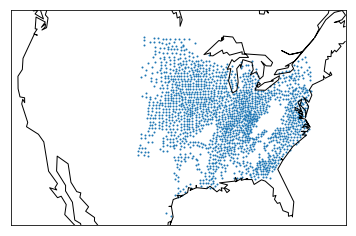

In [7]:
from mpl_toolkits.basemap import Basemap
%matplotlib inline
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
#m.readshapefile('st99_d00','states',drawbounds=True)
latitudes = list(X['lon'])

longitudes = list(X['lat'])
x, y = m(longitudes, latitudes)
# Use matplotlib to draw the points onto the map.
m.drawcoastlines()
m.scatter(x, y, s=1)
plt.show()

### In the starting kit, we only use data in one state

In [8]:
X_1 = pd.read_csv(datadir+"locations_final.csv",names=['loc1','loc2','lat','lon'])

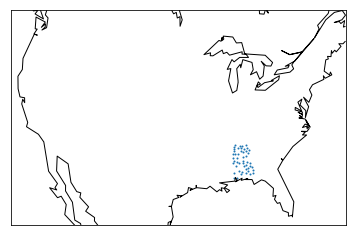

In [9]:
from mpl_toolkits.basemap import Basemap
%matplotlib inline
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
#m.readshapefile('st99_d00','states',drawbounds=True)
latitudes = list(X_1['lon'])
longitudes = list(X_1['lat'])
x, y = m(longitudes, latitudes)
# Use matplotlib to draw the points onto the map.
m.drawcoastlines()
m.scatter(x, y, s=1)
plt.show()

### Show list of crop yields in each locations from year 2003 to year 2016

In [10]:
Y = pd.read_csv("./data/yield_final.csv",names=['year','loc1','loc2','yield'])

In [11]:
Y.head()

,year,loc1,loc2,yield
0,2015,1,85,28.0
1,2015,1,105,27.7
2,2015,1,119,29.6
3,2015,1,3,43.4
4,2015,1,53,35.9


In [12]:
Y.describe()

,year,loc1,loc2,yield
count,368.000000,368.0,368.000000,368.000000
mean,2010.608696,1.0,66.396739,30.083424
std,4.091479,0.0,34.358507,14.425115
min,2003.000000,1.0,1.000000,0.000000
25%,2007.000000,1.0,43.000000,23.125000
50%,2011.000000,1.0,69.000000,33.850000
75%,2014.000000,1.0,93.000000,40.525000
max,2016.000000,1.0,129.000000,53.600000


### Show corp yield in America's land map in 2013, bigger point means higher yield

In [13]:
L = pd.read_csv(datadir+"locations_final.csv", names=['loc1','loc2','lat','lon'])
L['loc'] = L['loc1'].apply(str) + '_' + L['loc2'].apply(str)
combine = pd.merge(Y,L)
yield2013 = combine[combine['year']==2013]
yield2013.head()

,year,loc1,loc2,yield,lat,lon,loc
7,2013,1,105,35.5,-87.294,32.639,1_105
14,2013,1,119,33.0,-88.200,32.597,1_119
21,2013,1,3,41.9,-87.746,30.659,1_3
34,2013,1,53,40.2,-87.168,31.122,1_53
45,2013,1,99,42.1,-87.383,31.580,1_99


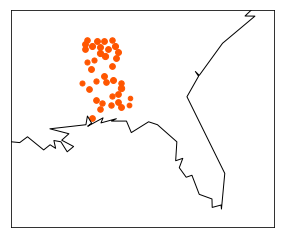

In [14]:
m = Basemap(llcrnrlon=-93,llcrnrlat=25,urcrnrlon=-75,urcrnrlat=35,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
#m.readshapefile('st99_d00','states',drawbounds=True)
latitudes = list(yield2013['lon'])
longitudes = list(yield2013['lat'])
yields = list(yield2013['yield'])
x, y = m(longitudes, latitudes)

max_yield = max(yields)
size_factor = 40.0 

for i,j,k in zip(x,y,yields):  
    size = size_factor*k/max_yield 
    m.scatter(i,j,s=size,marker='o',color='#FF5600')  



# Use matplotlib to draw the points onto the map.
m.drawcoastlines()

plt.show()

### Number of examples in each year
Each example is a series of remote sensor images in a whole year. In this problem you are going to use the serie of images to predict the that year's corp yierd.

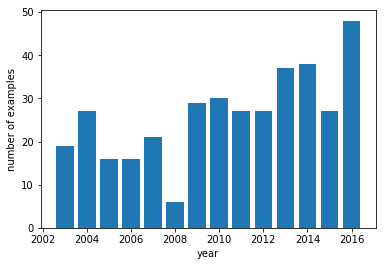

In [15]:
years = sorted(Y['year'].unique())
num = []
for year in years:
    num.append(Y[Y['year']==year]['year'].count())
plt.bar(years, num)
plt.xlabel('year')
plt.ylabel('number of examples')
plt.show()

## Preprocessing

### From raw data to local quadrangles

The remote sensoring image of each county has been saved in the directory 'data/data_image_full/'.Raw visualization of the full remote sensor image is  quite difficult, because a remote sensor image normally have many bands, each band comtains a lot of different informations. To show up the content of a remote sensor image, we give an example for a single band of image for entire county 

In [16]:
import gdal

In [17]:
X_raw = np.transpose(np.array(gdal.Open(MODIS_dir+'1_1.tif').ReadAsArray(), dtype='uint16'),axes=(1,2,0))

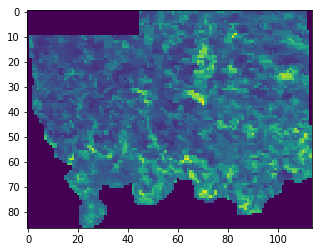

In [18]:
plt.imshow(X_raw[:,:,0])

However, the raw image contains too much informations. The raw image contains the remote sensor images in many year. It covers the whole region of county but we only care about images about farms. Also, it doesn't include temperature which is apparently strong relevant to corp yield. Thus, temperature layers are merged in and all regions which are not farms are masked out. To uniform the input, the masked region are unsampling to 48x48. The processed images are stored in directory 'data/img_zoom_full_output/'

### Processed image

In [20]:
X_train = []
for _, _, files in os.walk(img_zoom_output_dir):
    for f in files:
        if f.endswith('.npy'):
            X = np.load(img_zoom_output_dir+f)
            X_train.append(X)
    

In [21]:
len(X_train)

368

In [22]:
X_train[0].shape

(48, 48, 414)

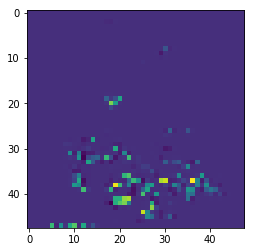

In [23]:
plt.imshow(X_train[0][:,:,0])

### Convert multi-bands images to histogram

In [24]:
data_yield = np.genfromtxt(datadir+'yield_final.csv', delimiter=',')
locations = np.genfromtxt(datadir+'locations_final.csv', delimiter=',')
length = data_yield.shape[0]
index_all = np.arange(length)

In [25]:
def image2histo(image_temp,start_day,end_day,bands):
    start_index=int(math.floor(start_day/8))*bands
    end_index=int(math.floor(end_day/8))*bands
    if end_index>image_temp.shape[2]:
        image_temp = np.concatenate((image_temp, 
            np.zeros((image_temp.shape[0],image_temp.shape[1],end_index-image_temp.shape[2]))),axis=2)
    return image_temp[:,:,start_index:end_index]

In [26]:
output_image_mean = np.zeros([index_all.shape[0], 32*9])
output_hist = []
output_yield = np.zeros([index_all.shape[0]])
output_year = np.zeros([index_all.shape[0]])
output_locations = np.zeros([index_all.shape[0],2])
output_index = np.zeros([index_all.shape[0],2])

for i in index_all:
    year = str(int(data_yield[i, 0]))
    loc1 = str(int(data_yield[i, 1]))
    loc2 = str(int(data_yield[i, 2]))

    key = np.array([int(loc1),int(loc2)])
    index = np.where(np.all(locations[:,0:2].astype('int') == key, axis=1))
    longitude = locations[index,2]
    latitude = locations[index,3]
    
    filename = year + '_' + loc1 + '_' + loc2 + '.npy'
    
    if os.path.isfile(img_zoom_output_dir + filename):
    
        image_temp = np.load(img_zoom_output_dir + filename)
        image_temp = image2histo(image_temp, 49, 305, 9)
        
        image_temp1 = np.sum(image_temp,axis=(0,1))/np.count_nonzero(image_temp)*image_temp.shape[2]
        image_temp1[np.isnan(image_temp1)] = 0
        
        hist_oneyear = []
        hist_onestep = []
        for j in range(288):
            hist = np.histogram(image_temp[:,:,j], bins=64, range=(-200.0, 2000.0))
            hist_onestep.append(hist)
            j+=1
            if j % 9 == 0:
                hist_oneyear.append(hist_onestep)
                hist_onestep = []
            
        output_hist.append(hist_oneyear)    
            
        
        
            
        output_image_mean[i, :] = image_temp1
        output_yield[i] = data_yield[i, 3]
        output_year[i] = int(year)
        output_locations[i, 0] = longitude
        output_locations[i, 1] = latitude
        output_index[i,:] = np.array([int(loc1),int(loc2)])
    else:
        print filename, 'not exist'
    print i,np.sum(image_temp1),year,loc1,loc2
        

0 15757.749663 2015 1 85
1 15547.8280646 2015 1 105
2 5236.93601094 2015 1 119
3 32404.4370524 2015 1 3
4 49936.8494976 2015 1 53
5 14505.0782883 2015 1 99
6 2959.92070724 2015 1 9
7 18047.602566 2015 1 19
8 9014.50937108 2015 1 43
9 8030.85205653 2015 1 49
10 8027.00786774 2015 1 55
11 8524.21384976 2015 1 71
12 86965.7108594 2015 1 33
13 66280.33163 2015 1 77
14 88733.0474633 2015 1 79
15 197792.692169 2015 1 83
16 189486.574072 2015 1 89
17 41458.1542821 2015 1 103
18 5879.88550434 2015 1 21
19 4232.24428575 2015 1 57
20 10905.6916437 2015 1 121
21 8511.35328827 2015 1 125
22 11277.4049811 2015 1 5
23 8043.04194833 2015 1 39
24 113106.68248 2015 1 61
25 126070.915956 2015 1 69
26 10662.0598484 2015 1 109
27 6538.81797484 2014 1 11
28 25283.2750464 2014 1 51
29 6402.36380107 2014 1 63
30 23120.6645151 2014 1 85
31 17025.5786164 2014 1 87
32 38489.9363836 2014 1 101
33 15777.6553648 2014 1 105
34 4798.6340363 2014 1 119
35 32690.6747936 2014 1 3
36 43682.7513017 2014 1 53
37 10782.836

300 288672.049483 2004 1 69
301 54654.1633678 2003 1 3
302 51017.5181192 2003 1 53
303 23906.9700478 2003 1 15
304 40615.3501974 2003 1 19
305 30875.2075631 2003 1 43
306 18144.4232122 2003 1 49
307 21957.5052851 2003 1 55
308 16586.0274241 2003 1 71
309 31921.142934 2003 1 95
310 109455.638283 2003 1 77
311 140072.144101 2003 1 79
312 263838.180476 2003 1 83
313 242887.330384 2003 1 89
314 14040.4173367 2003 1 93
315 61791.1801776 2003 1 103
316 8426.39440136 2003 1 57
317 20634.587269 2003 1 121
318 402700.258798 2003 1 61
319 302058.528116 2003 1 69
320 23186.8178175 2016 1 85
321 15933.7446424 2016 1 105
322 4847.82169037 2016 1 119
323 31752.9138439 2016 1 3


/Users/moyang/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/moyang/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


324 0.0 2016 1 53
325 11058.4005921 2016 1 99
326 6360.0919442 2016 1 9
327 32844.1949817 2016 1 19
328 14868.2883937 2016 1 43
329 14483.8067212 2016 1 49
330 13144.5584027 2016 1 55
331 10919.0400305 2016 1 71
332 105903.869754 2016 1 33
333 90513.388898 2016 1 77
334 0.0 2016 1 79
335 233837.443122 2016 1 83
336 226841.522712 2016 1 89
337 47999.8492993 2016 1 103
338 5574.4595982 2016 1 21
339 6254.82081846 2016 1 57
340 11846.6882147 2016 1 121
341 7178.95559846 2016 1 125
342 11414.576701 2016 1 5
343 7739.25225434 2016 1 39
344 121274.537908 2016 1 61
345 146515.66202 2016 1 69
346 9110.55406638 2016 1 109
347 6536.0327105 2016 1 11
348 0.0 2016 1 51
349 6287.17323751 2016 1 63
350 17321.2108664 2016 1 87
351 38835.1216 2016 1 101
352 2604.10511677 2016 1 129
353 14014.1800452 2016 1 15
354 16710.1000865 2016 1 95
355 38167.8467562 2016 1 59
356 16626.9227711 2016 1 117
357 3887.65354201 2016 1 127
358 0.0 2016 1 31
359 130221.007671 2016 1 67
360 20463.8039781 2016 1 1
361 6860

#### Number of examples

In [27]:
len(output_hist)

368

#### In each example, the number of time steps

In [28]:
len(output_hist[0])

32

#### In each time step, the number of histograms

In [29]:
len(output_hist[0][0])

9

#### Numeric form of a histogram

In [30]:
output_hist[0][0][0]

(array([   4,    7,   10,    9,   27, 2061,   53,   26,   17,    4,    4,
           4,    3,    1,    1,    0,    3,    1,    2,    0,    1,    0,
           0,    0,    1,    0,    1,    0,    0,    2,    1,    2,    1,
           0,    0,    1,    1,    0,    1,    0,    2,    0,    2,    2,
           1,    0,    0,    0,    1,    2,    0,    1,    1,    0,    0,
           0,    1,    0,    1,    0,    0,    0,    0,    0]),
 array([ -200.   ,  -165.625,  -131.25 ,   -96.875,   -62.5  ,   -28.125,
            6.25 ,    40.625,    75.   ,   109.375,   143.75 ,   178.125,
          212.5  ,   246.875,   281.25 ,   315.625,   350.   ,   384.375,
          418.75 ,   453.125,   487.5  ,   521.875,   556.25 ,   590.625,
          625.   ,   659.375,   693.75 ,   728.125,   762.5  ,   796.875,
          831.25 ,   865.625,   900.   ,   934.375,   968.75 ,  1003.125,
         1037.5  ,  1071.875,  1106.25 ,  1140.625,  1175.   ,  1209.375,
         1243.75 ,  1278.125,  1312.5  ,  1346.8

#### Histogram graph

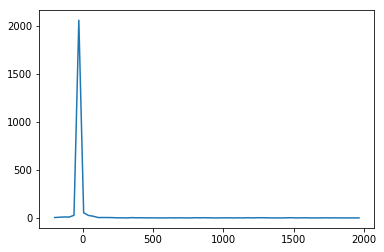

In [31]:
(y,x) = output_hist[0][0][0]
plt.plot(x[:-1],y)

### histogram mean time step

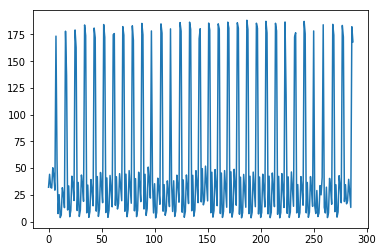

In [32]:
plt.plot(output_image_mean[0])

### delete those whose yield = 0

In [33]:
delete_list = []
for i in range(output_image_mean.shape[0]):
    if output_yield[i] < 5.0:
        delete_list.append(i)

In [34]:
X = np.delete(output_hist,delete_list,0)
Y = np.delete(output_yield,delete_list,0)
X_mean = np.delete(output_image_mean,delete_list,0)

In [35]:
X.shape

(320, 32, 9, 2)

In [36]:
np.savez(datadir+'data.npz', 
        X=X,Y=Y,X_mean=X_mean,output_year=output_year,output_locations=output_locations,output_index=output_index)

### split into train and test. Attention, here, in consideratoin of time series problem, we take 2015 for test-set. 

In [37]:
data = np.load(datadir+'data.npz')

In [ ]:
X = data['X']
Y = data['Y']
X_mean = data['X_mean']
output_year = data['output_year']
output_locations = data['output_locations']

In [60]:
predict_year = 2015

In [61]:
index_train = np.nonzero(output_year < predict_year)[0]
index_test = np.nonzero(output_year == predict_year)[0]

In [64]:
X_train = X[index_train]
X_test = X[index_train]
Y_train = Y[index_train]
Y_test = Y[index_test]
X_mean_train = X_mean[index_train]
X_mean_test = X_mean[index_test]

In [65]:
np.savez(datadir+'train.npz', 
        X=X_train,Y=Y_train,X_mean=X_mean_train)
np.savez(datadir+'test.npz', 
        X=X_test,Y=Y_test,X_mean=X_mean_test)

In [68]:
X_mean_train.shape

(293, 288)

## Regressor
The regressor follows a classical scikit-learn regressor template. It should be saved in the file submissions/starting_kit/classifier.py. In its simplest form it takes a scikit-learn pipeline, assigns it to self.clf in __init__, then calls its fit and predict_proba functions in the corresponding member functions.

In [87]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor


class Regressor(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.reg = RandomForestRegressor(
            n_estimators=200, max_leaf_nodes=2, random_state=61)
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

## Local testing
It is important that you test your submission files before submitting them. For this we provide a unit test. Note that the test runs on your files in submissions/starting_kit, not on the classes defined in the cells of this notebook.  

First pip install ramp-workflow or install it from the github repo. Make sure that the python files feature_extractor.py and classifier.py are in the  submissions/starting_kit folder, and the data train.csv and test.csv are in data. Then run  

ramp_test_submission  

If it runs and print training and test errors on each fold, then you can submit the code.  

In [88]:
!ramp_test_submission --quick-test

Testing Crop yield prediction
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
./submissions/starting_kit/feature_extractor.py:1: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  import pandas as pd
./submissions/starting_kit/feature_extractor.py:2: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  import numpy as np
./submissions/starting_kit/feature_extractor.py:3: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  from sklearn import preprocessing
./submissions/starting_kit/regressor.py:1: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  from sklearn.base import BaseEstimator
./submissions/starting_kit/regressor.py:2: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  from